## Building Univariate Time Series Models using Statistical Methods

Some popuar statistical modeling methods include

* exponential smooting
* non-seasonal autoregressive integrated moving average (ARIMA)
* seasonal ARIMA (SARIMA)
* Vector Autoregressive (VAR)


In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import warnings 
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse 
from sklearn.metrics import mean_absolute_percentage_error as mape 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from itertools import product 
from pathlib import Path 
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [2]:
# import data 
life_file = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/life_expectancy_birth.csv')
milk_file = Path('../TimeSeriesAnalysisWithPythonCookbook/Data/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year', 
                   parse_dates=True, 
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)


<AxesSubplot:title={'center':'Monthly Milk Production'}, xlabel='month'>

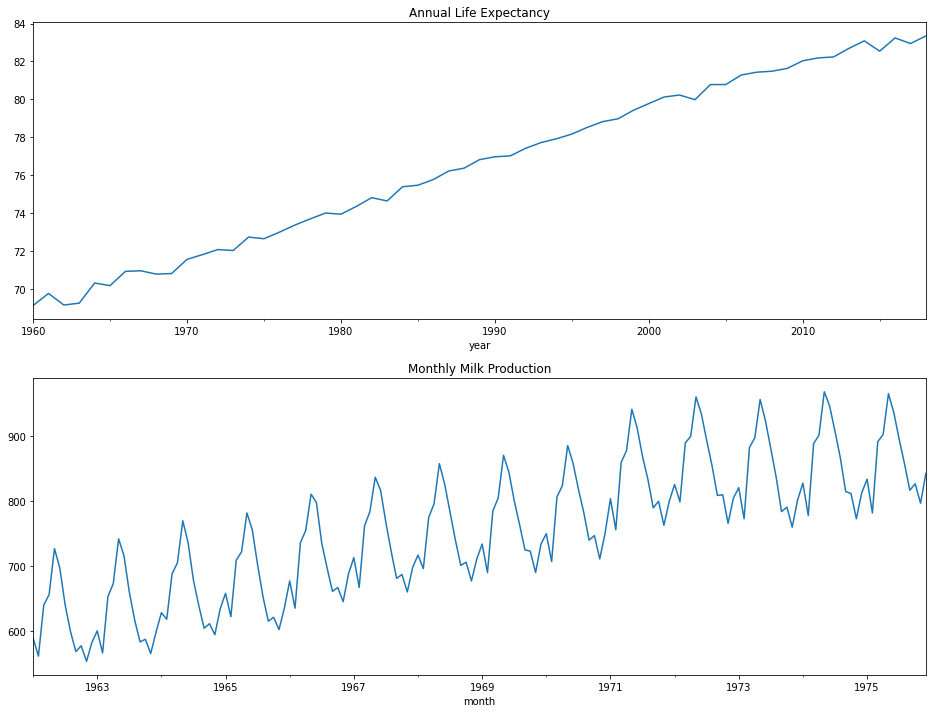

In [4]:
# inspect the data visually and obeserve if the time series contains any trend or seasonality

fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title="Annual Life Expectancy", 
          legend=False, ax=ax[0])

milk.plot(title="Monthly Milk Production", 
          legend=False, ax=ax[1])

In [7]:
# Create a function to split data into test and train sets 

def split_data(data, test_split): 
    l = len(data)
    t_idx = round(l*(1-test_split))
    train,test = data[:t_idx], data[t_idx:]
    print(f'train: {len(train)}, test: {len(test)}')
    return train, test 

In [8]:
# Call the split_data function to split the DataFrames into test and train sets (15% test and 85% train)

test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)


train: 143, test: 25
train: 50, test: 9


In [9]:
# Create a function for checking for stationarity

def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = "Stationary"
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return(s, results[0])


In [10]:
# Create function for hyperparameter tuning

def get_best_model(score, c="AIC"):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k 
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']


In [11]:
# Create the plot_forecast function which takes a model object that we have trained, a starting position and both the train and test datasets to create
# a plot that compares the forecast against actuals

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)

    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax) 
    forecast.plot(ax=ax, style='-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()
    

In [12]:
# Create a function that takes a list of parameters and returns a Cartesian product of these choices

def combinator(items):
    combo = [i for i in product(*items)]
    return combo 


## Plotting ACF and PACF


The ACF and PACF plots can help identify if the time series process is an AR, MA or ARMA process (if both are present) and the significant lag values (for p and q)

Both PACF and ACF plots are referred to as **correlograms** since the plots represent the correlation statistics

* ARMA assumes a stationary process
* ARIMA models does not since it handles the differencing

#### AR order vs. MA order 

* PACF plot estimates the AR order 
* ACF plot estimates the MA order

Statsmodels provides two functions: acf_plot and pacf_plot 

The correlation at lag zero is always one

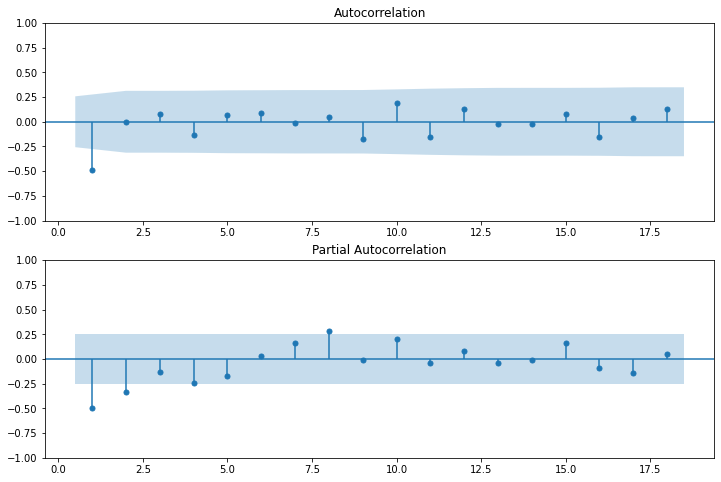

In [13]:
# differencing the time series 

life_diff = life.diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(12, 8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
plt.show()

In [14]:
milk_diff_12 = milk.diff(12).dropna()

In [15]:
# Use the check_stationarity function to perform an ADF test to check for stationarity

check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.16079880527711288 	 lags:12


('Non-Stationary', 0.16079880527711288)

In [16]:
# Perform a second differencing 
milk_diff_12_1 = milk.diff(12).diff(1).dropna()


In [17]:
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878859e-05 	 lags:11


('Stationary', 1.865423431878859e-05)

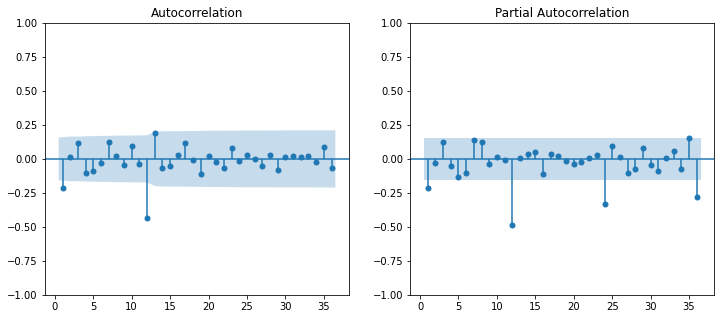

In [18]:
# Plot ACF and PACF for the stationary time series in milk_diff_12_1

fig,ax = plt.subplots(1,2)
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
plt.show()


ACF plot: 
* significant spike at lag 1, which represents the non-seasonal order for the MA process as q=1
* the spike at lag 12 represents the seasonal order for the MA process as Q=1. Notice that there is a cut-off right after lag 1, then a spike at lag 12, followed by a cut-off (no other significant lags afterward). These indicate a moving average model: an MA(1) for the non-seasonal component and an MA(1) for the seasonal component. 

PACF: 
* an exponential decay at lags 12, 24 and 36 indicates an Ma model. So the SARIMA model would be ARIMA (0, 1, 1)(0, 1, 1, 12)
 
The ACF and PACF plots can help us understand the strength of the linear relationship between past observations and their significance at different lags 

The ACF and PACF plot show significant autocorrelation or partial autocorrelation above the confindence interval. The shaded portion represents the confidence interval, which is controlled by the _alpha_ parameter in pacf_plot and acf_plot functions. The default value for alpha in statsmodels is 0.05. Being significant could be in either direction; strongly positive the close to 1 (above) or strongly negative the closer to -1 (below)

Example guide: 

Process                 ACF                                         PACF
AR(p)                 Gradual decay after lag p                   Cut-off after lag p

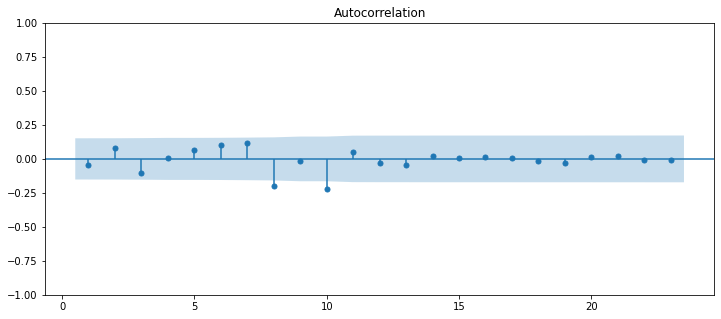

In [19]:
# ACF plot used to diagnose the model's residuals 
# build the seasonal ARIMA model as SARIMA(0,1,1)(0,1,1,12)
# then use the ACF to diagnose the residuals. If the model captured all the information that's 
# been embedded within the time series, we would expect the residuals to have no autocorrelation 

from statsmodels.tsa.statespace.sarimax import SARIMAX 
model = SARIMAX(milk, order=(0,1,1), 
                seasonal_order=(0,1,1,12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
plt.show()


Overall there are a couple of slightly significant lags, indicating the existence of some autocorrelation in the residuals. When the residuals show autocorrelation, this can mean that the model did not capture all the information, and there is potential for further improvement

We can further tune the model and experiment with other values for the seasonal and non-seasonal orders. 

## Forecasting univariate time series data with exponential smoothing 

In statsmodels there are three different implementations of exponential smooting, depending on the nature of the data we are working with

* **SimpleExpSmoothing** - Simple exponential smoothing is used when the time series process lacks seasonality and trend. This is also referred to as single exponential smoothing

* **Holt** - Holt's exponential smoothing is an enhancement of the simple exponential smoothing and is used when the time series process contains only trend (but no seasonality). It is referred to as double exponential smoothing

* **ExponentialSmoothing** - Holt-Winters' exponential smoothing is an enchancement of Holt's exponential smoothing and is used when the time series process has both seasonality and trend. It is referred to as triple exponential smoothing

In [20]:
# Import the ExponentialSmoothing class 
from statsmodels.tsa.api import ExponentialSmoothing


The ExponentialSmoothing takes several parameters

* smoothing_level: A float value for the smoothing factor for the level known as alpha 
* smoothing_trend: A float value for the smoothing factor for the trend  known as beta 
* smoothing_seasonal: A float value for the smoothing factor for the seasonal trend known as gamma
* trend: A single choic from (multiplicative or muk), (additive or add) or None 
* seasonal_periods: Takes an integer value representing the seasonality period, for ex. 12 (monthly) or 4 (quarterly)
* damped_trend: A Boolean value that is either True or False 
* use_boxcox: A Boolean value that is either True or False to determine if a Box-Cox transform should be applied

We can use the ExponentialSmoothing class to find the optimal values for alpha, beta and gamma



In [21]:
# Use the LifeExpectancy dataset and use the ExponentialSmoothing class

# For the life DataFrame we only have trend, so we only need to explore different values for the two parameters 
# that is, trend and damped

trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb 

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [24]:
# Loop through the combination list and train a different model at each iteration. 
# Capture the evaluation metrics in a dictionary to compare the results later. 

train = life_train.values.ravel()
y = life_test.values.ravel()

score = {}

for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                               trend=t, 
                               damped_trend = dp, 
                               seasonal = None)
    
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    score[i] = {'trend': t, 
                'damped': dp, 
                'AIC': model.aic, 
                'BIC': model.bic, 
                'AICc': model.aicc, 
                'RMSPE': rmspe(y, y_hat), 
                'RMSE': rmse(y, y_hat), 
                'MAPE': mape(y, y_hat), 
                'model': model}
    
    



To retrieve the best model using the get_best_model function, just pass the scores dictionary. For now, keep the default criteria set to c=AIC to be consistent

In [25]:
life_best_model = get_best_model(score, 'AIC')


Best model: 1 with lowest AIC score: -137.030601787416


In [26]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Sun, 09 Apr 2023"
Box-Cox:,False,Time:,01:28:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621954,alpha,True
smoothing_trend,0.1621954,beta,True


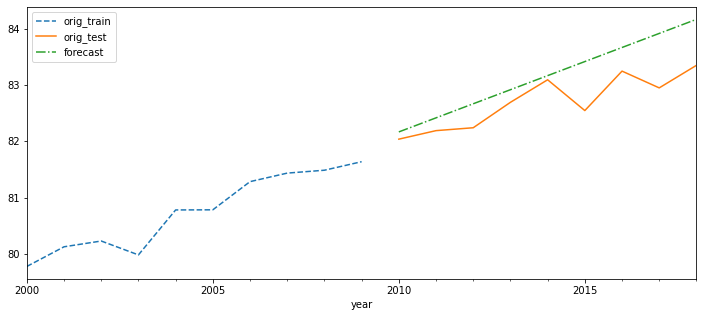

In [27]:
# We can forecast future values using the forecast method and then evaluate the results 
# against the test set
# the plot_forecast() function will produce the forecast and plot the results 

plot_forecast(life_best_model, '2000', life_train, life_test)

Replicate the process but using the milk dataframe. Keep in mind that the most significant difference here is the addition of the seasonal parameters. This means we will be adding two additional hyperparameters to evaluate for; seasonal and seasonal_periods

Build a cartesian product for the different options. For seasonal_periods we can explore three periods - 4, 6 and 12 months. This should give us a total of 24 models (2 x 2 x 2 x 3) = 24 

In [28]:
trend, damped = ['add', 'mul'], [True, False]
seasonal, periods = ['add', 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])


In [30]:
# Loop through the list of combinations to train multiple models and capture their scores :

train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}

for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                               trend=t,
                               damped_trend = dp, 
                               seasonal=s,
                               seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend': t, 
                            'damped': dp,
                            'AIC': model.aic, 
                            'BIC': model.bic, 
                            'AICc': model.aicc, 
                            'RMSPE': rmspe(y, y_hat), 
                            'RMSE': rmse(y, y_hat), 
                            'MAPE': mape(y, y_hat), 
                            'model': model}

milk_model = get_best_model(milk_model_scores)
    

Best model: 8 with lowest AIC score: 593.7138861998106


In [31]:
# Print the model' summary 
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Sun, 09 Apr 2023"
Box-Cox:,False,Time:,01:45:08
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6858697,alpha,True
smoothing_trend,3.8173e-08,beta,True


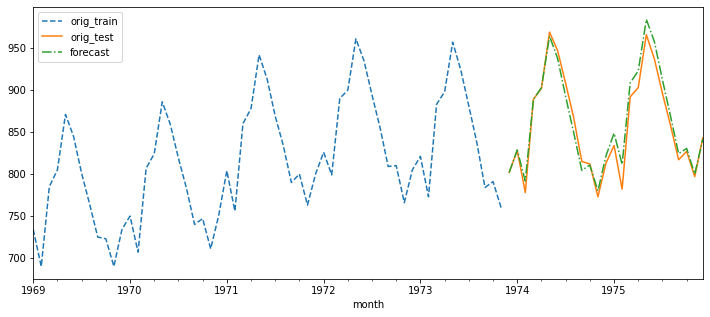

In [32]:
# Compare our forecast using the best model against the test data: 
plot_forecast(milk_model, '1969', milk_train, milk_test)


## Forecasting univariate time series data with non-essential ARIMA